In [1]:
import json
import infosys.utils as utils 
import igraph as ig
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl

In [2]:
ABS_PATH = '/N/slate/baotruon/marketplace'
DATA_PATH = '/N/slate/baotruon/marketplace/data'

print(os.getcwd())
exp_configs = json.load(open(os.path.join(DATA_PATH, 'all_configs.json'),'r'))
EXPS = list(exp_configs['vary_thetaphi'].keys()) #keys are name of exp, format: '{targeting}_{thetaidx}{phiidx}' 

# map available network in `vary_targetgamma` corresponding with the exp
# networks from `vary_targetgamma` has format: '{targeting}{gamma}'
GAMMA = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]
TARGETING = [None, 'hubs', 'partisanship', 'conservative', 'liberal', 'misinformation']

EXP_NETWORK = {}

gamma = 0.1 # gamma in the range where targeting has some effect
# need to match with default_targeting
for exp in EXPS:
    if 'none' in exp:
        networkname = '%s%s' %(TARGETING.index(None), GAMMA.index(gamma))
    else: 
        networkname = '%s%s' %(TARGETING.index(exp.split('_')[0]), GAMMA.index(gamma) )
    EXP_NETWORK[exp] = networkname

/geode2/home/u010/baotruon/Carbonate/marketplace/exps


In [7]:
EXP_NETWORK['none_04']

'08'

In [8]:
EXP_NETWORK['hubs_04']

'18'

In [3]:
sim_num = 1
mode='igraph'
RES_DIR = os.path.join(ABS_PATH,'results', 'vary_thetaphi_%sruns' %sim_num)
TRACKING_DIR = os.path.join(ABS_PATH,'long_results', 'vary_thetaphi_%sruns' %sim_num)

In [19]:
exp_no = 'none_04'
fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)

In [20]:
network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])

In [21]:
G = ig.Graph.Read_GML(network)

In [7]:
len([n for n in G.vs if n['bot']==0])

10006

In [13]:
verbose = utils.read_json_compressed(fpath)

In [13]:
#verbose['all_memes']

In [24]:
spreading = [node for meme in verbose['all_memes'] for node in meme['spread_via_agents']]

In [18]:
verbose['all_memes'][0]

[{'id': 1,
  'is_by_bot': 0.0,
  'phi': 1,
  'quality': 0.4692894983895298,
  'fitness': 0.4692894983895298,
  'human_shares': 1,
  'bot_shares': 0,
  'spread_via_agents': [6418],
  'qual_th': 76816,
  'share_th': 64892},
 {'id': 2,
  'is_by_bot': 0.0,
  'phi': 1,
  'quality': 0.1163730344695505,
  'fitness': 0.1163730344695505,
  'human_shares': 1,
  'bot_shares': 0,
  'spread_via_agents': [8400],
  'qual_th': 24162,
  'share_th': 22141},
 {'id': 3,
  'is_by_bot': 0.0,
  'phi': 1,
  'quality': 0.18068785874372073,
  'fitness': 0.18068785874372073,
  'human_shares': 1,
  'bot_shares': 0,
  'spread_via_agents': [1256],
  'qual_th': 35576,
  'share_th': 32143},
 {'id': 4,
  'is_by_bot': 0.0,
  'phi': 1,
  'quality': 0.14256396141231165,
  'fitness': 0.14256396141231165,
  'human_shares': 5,
  'bot_shares': 0,
  'spread_via_agents': [2158, 5507, 6349, 4127, 309],
  'qual_th': 28998,
  'share_th': 100904},
 {'id': 5,
  'is_by_bot': 0.0,
  'phi': 1,
  'quality': 0.2728762964072863,
  'fitne

## Deg histogram of the network

(array([7036., 1708.,  633.,  265.,  162.,  187.,   56.,   32.,   16.,
          11.]),
 array([   4. ,  186.9,  369.8,  552.7,  735.6,  918.5, 1101.4, 1284.3,
        1467.2, 1650.1, 1833. ]),
 <BarContainer object of 10 artists>)

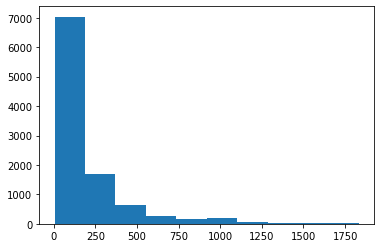

In [14]:
graph = G
vertices = range(len(graph.vs)) #vertices index
degs = graph.degree(vertices, mode='in', loops=False)
plt.hist(degs)

# Plot number of shares a meme gets vs the indeg of the spreading channel 
Let's say hubs are those with indeg>=15. 

## Bot memes

In [35]:
shares = [meme['human_shares'] + meme['bot_shares'] for meme in verbose['all_memes'] if meme['is_by_bot']==1]

In [17]:
shares=[]
avg_indegs = []
largest_indegs=[]
for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
    if meme['is_by_bot']==1:
        shares+= [meme['human_shares'] + meme['bot_shares']]
        spread_through= [int(node) for node in meme['spread_via_agents']]
        indegs = graph.degree(spread_through, mode=mode, loops=False)
        avg_indegs += [np.mean(indegs)]
        largest_indegs += [max(indegs)]

Text(0, 0.5, 'shares')

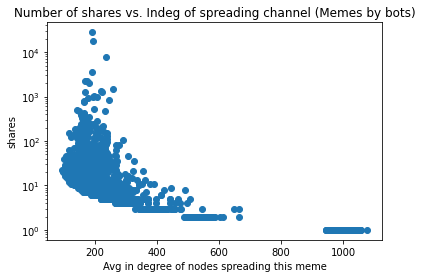

In [20]:
plt.scatter(avg_indegs, shares)
plt.title('Number of shares vs. Indeg of spreading channel (Memes by bots)')
plt.yscale('log')
plt.xlabel('Avg in degree of nodes spreading this meme')
plt.ylabel('shares')

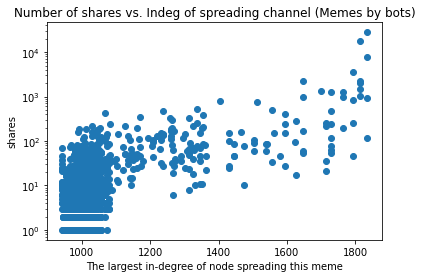

In [24]:
plt.scatter(largest_indegs, shares)
plt.title('Number of shares vs. Indeg of spreading channel (Memes by bots)')
plt.xlabel('The largest in-degree of node spreading this meme')
plt.ylabel('shares')
plt.yscale('log')

--> Seems like every meme goes through a hub

## Plot for hubs and no targeting

In [4]:
def numshares_vs_indeg(exp_no):
    mode='igraph'
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    print('network: ', network)
    deg_mode='in'
    shares=[]
    avg_indegs = []
    largest_indegs=[]
    all_indegs = []
    print(verbose.keys())
    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        if meme['is_by_bot']==1:
            shares+= [meme['human_shares'] + meme['bot_shares']]
            spread_through= [int(node) for node in meme['spread_via_agents']]
            indegs = G.degree(spread_through, mode=deg_mode, loops=False)
            all_indegs +=[indegs]
            avg_indegs += [np.mean(indegs)]
            largest_indegs += [max(indegs)]
    return shares, all_indegs, avg_indegs, largest_indegs

In [7]:
nohub = 'none_04'
hub = 'hubs_04'
shares, all_indegs, avg_indegs, largest_indegs = numshares_vs_indeg(nohub)
hubshares, huball_indegs, hubavg_indegs, hublargest_indegs = numshares_vs_indeg(hub)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml
dict_keys(['targeting_criterion', 'theta', 'phi', 'verbose', 'human_network', 'beta', 'gamma', 'graph_gml', 'mode', 'quality', 'diversity', 'discriminative_pow', 'quality_timestep', 'all_memes', 'all_feeds'])
network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_18.gml
dict_keys(['targeting_criterion', 'theta', 'phi', 'verbose', 'human_network', 'beta', 'gamma', 'graph_gml', 'mode', 'quality', 'diversity', 'discriminative_pow', 'quality_timestep', 'all_memes', 'all_feeds'])


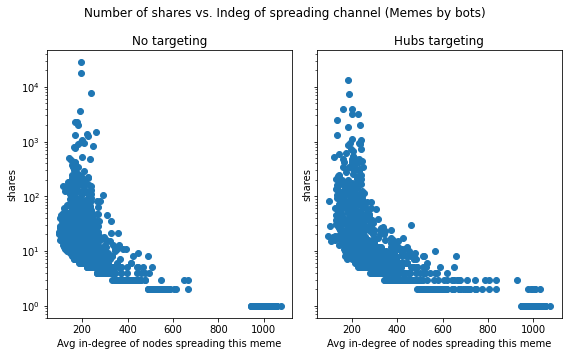

In [8]:
fig, (ax1,ax2)= plt.subplots(1,2, sharey=True, sharex=True, figsize=(8,5))
ax1.scatter(avg_indegs, shares)
ax1.set_title('No targeting')
ax1.set_xlabel('Avg in-degree of nodes spreading this meme')
ax1.set_ylabel('shares')
ax1.set_yscale('log')

ax2.scatter(hubavg_indegs, hubshares)
ax2.set_title('Hubs targeting')
ax2.set_xlabel('Avg in-degree of nodes spreading this meme')
ax2.set_ylabel('shares')

fig.suptitle('Number of shares vs. Indeg of spreading channel (Memes by bots)')
fig.tight_layout()

In [41]:
# fig, ax= plt.subplots()
# ax.hist(all_indegs, label='no targeting')
# ax.hist(hubindegs, label='hubs targeting')
# plt.legend()
# plt.xlabel('in-degree of spreading channels')
# plt.ylabel('freq')
# plt.title('Distribution of in-degree of spreading channels (memes by bots)')

In [44]:
common_node = verbose['all_memes'][0][0]['spread_via_agents']
print(common_node)
for idx, meme in enumerate(verbose['all_memes'][0][1:]):
    common_node = set(meme['spread_via_agents']) & set(common_node)
print(common_node)

[6312]
set()


--> They don't go through the same nodes, but nodes with same indeg

## CCDF

In [3]:
def indeg_spreading_channels(exp_no):
    mode='igraph'
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
#     print('network: ', network)
    deg_mode='in'
    
    bot_largest_spreading_nodes = []
    human_largest_spreading_nodes = []
    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations

        spread_through= [int(node) for node in meme['spread_via_agents']]
        indegs = G.degree(spread_through, mode=deg_mode, loops=False)
        largest_indeg = max(indegs)
        if meme['is_by_bot']==1:
            bot_largest_spreading_nodes += [largest_indeg]  
        else:
            human_largest_spreading_nodes += [largest_indeg]

    return bot_largest_spreading_nodes, human_largest_spreading_nodes

In [9]:
nohub = 'none_04'
hub = 'hubs_04'
bot_spread, human_spread= indeg_spreading_channels(nohub)
hubs_bot_spread, hubs_human_spread= indeg_spreading_channels(hub)

Text(0.5, 0.98, 'CCDF: Largest in-deg of spreading nodes (across whole simulation)')

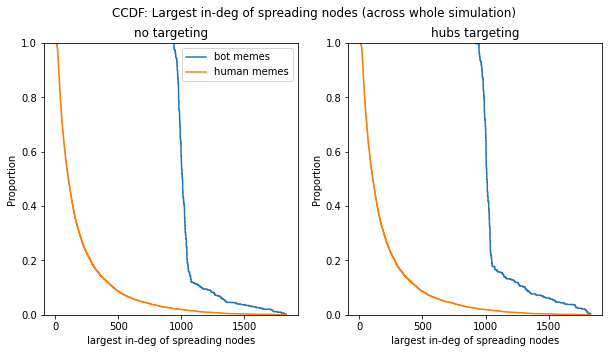

In [15]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5), sharex=True)

sns.ecdfplot(ax=ax1, data = bot_spread, complementary=True, label = 'bot memes')
sns.ecdfplot(ax=ax1, data = human_spread, complementary=True, label = 'human memes')
ax1.legend()
# ax1.set_xscale('log')

sns.ecdfplot(ax=ax2, data = hubs_bot_spread, complementary=True, label = 'bot memes')
sns.ecdfplot(ax=ax2, data = hubs_human_spread, complementary=True, label = 'human memes')

ax1.set_title('no targeting')
ax2.set_title('hubs targeting')
ax1.set_xlabel('largest in-deg of spreading nodes')
ax2.set_xlabel('largest in-deg of spreading nodes')

figure.suptitle('CCDF: Largest in-deg of spreading nodes (across whole simulation)')
# ax.set_xlim([0, 1])

# Separate between hub nodes and non-hub nodes 

In [57]:
exp_no='none_04'
network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
G = ig.Graph.Read_GML(network)
verbose = utils.read_json_compressed(fpath)
print('network: ', network)

hub_meme_share = []
nonehub_meme_share = []
hub_size=300

for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
    if meme['is_by_bot']==1:
        shares = meme['human_shares'] + meme['bot_shares']
        spread_through= [int(node) for node in meme['spread_via_agents']]
        indegs = graph.degree(spread_through, mode=mode, loops=False)
        viahubs = [i for i in indegs if i>=hub_size]
        if len(viahubs)>0:
            #meme went through at least 1 hub
            hub_meme_share += [shares]
        else:
            nonehub_meme_share += [shares]

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml


/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.
  app.launch_new_instance()


Text(0.5, 1.0, 'Distribution of shares of bot memes')

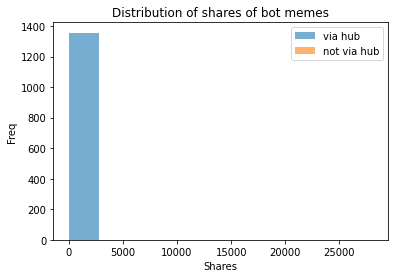

In [55]:
alpha=0.6
fig, ax= plt.subplots()
ax.hist(hub_meme_share, label='via hub', alpha=alpha)
ax.hist(nonehub_meme_share, label='not via hub', alpha=alpha)
ax.legend()
ax.set_xlabel('Shares')
ax.set_ylabel('Freq')
ax.set_title('Distribution of shares of bot memes')

## plot for 2 strategies

In [82]:
def shares_separate_by_hubs(exp_no, hub_size=1000, allshare=True):
    mode='igraph'
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    print('network: ', network)
    deg_mode='in'
    hub_meme_share = []
    nonehub_meme_share = []

    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        if meme['is_by_bot']==1:
            if allshare is True:
                shares = meme['human_shares'] + meme['bot_shares']
            else:
                shares = meme['human_shares']
            spread_through= [int(node) for node in meme['spread_via_agents']]
            indegs = G.degree(spread_through, mode=deg_mode, loops=False)
            viahubs = [i for i in indegs if i>=hub_size]
            if len(viahubs)>0:
                #meme went through at least 1 hub
                hub_meme_share += [shares]
            else:
                nonehub_meme_share += [shares]
    return hub_meme_share, nonehub_meme_share

All shares

In [83]:
allshare=True
nohub = 'none_04'
hub = 'hubs_04'
hub_meme_share, nonehub_meme_share = shares_separate_by_hubs(nohub, allshare=allshare)
hubs_hub_meme_share, hubs_nonehub_meme_share = shares_separate_by_hubs(hub, allshare=allshare)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml


/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.


network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_18.gml


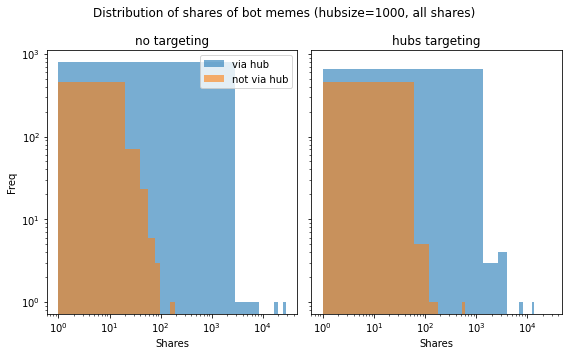

In [84]:
alpha=0.6
fig, (ax1,ax2)= plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,5))
ax1.hist(hub_meme_share, label='via hub', alpha=alpha)
ax1.hist(nonehub_meme_share, label='not via hub', alpha=alpha)
ax1.legend()
ax1.set_xlabel('Shares')
ax1.set_ylabel('Freq')
ax1.set_title('no targeting')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.hist(hubs_hub_meme_share, label='via hub', alpha=alpha)
ax2.hist(hubs_nonehub_meme_share, label='not via hub', alpha=alpha)
ax2.set_title('hubs targeting')
ax2.set_xlabel('Shares')

fig.suptitle('Distribution of shares of bot memes (hubsize=1000, all shares)')
fig.tight_layout()

Only human shares

In [85]:
allshare=False
nohub = 'none_04'
hub = 'hubs_04'
hub_meme_share, nonehub_meme_share = shares_separate_by_hubs(nohub, allshare=allshare)
hubs_hub_meme_share, hubs_nonehub_meme_share = shares_separate_by_hubs(hub, allshare=allshare)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml


/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.


network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_18.gml


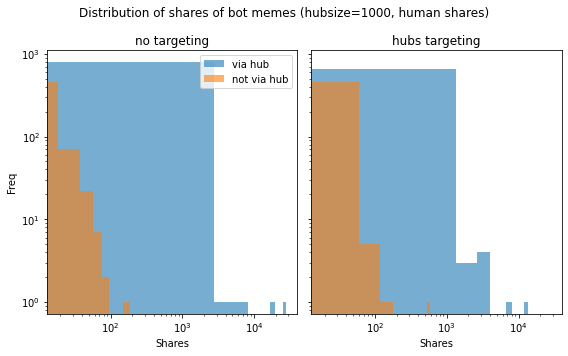

In [86]:
alpha=0.6
fig, (ax1,ax2)= plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,5))
ax1.hist(hub_meme_share, label='via hub', alpha=alpha)
ax1.hist(nonehub_meme_share, label='not via hub', alpha=alpha)
ax1.legend()
ax1.set_xlabel('Shares')
ax1.set_ylabel('Freq')
ax1.set_title('no targeting')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.hist(hubs_hub_meme_share, label='via hub', alpha=alpha)
ax2.hist(hubs_nonehub_meme_share, label='not via hub', alpha=alpha)
ax2.set_title('hubs targeting')
ax2.set_xlabel('Shares')

fig.suptitle('Distribution of shares of bot memes (hubsize=1000, human shares)')
fig.tight_layout()

## Human vs bot memes separated by hubs¶


In [4]:
def shares_separate_by_hubs(exp_no, hub_size=1000, allshare=True):
    mode='igraph'
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    print('network: ', network)
    deg_mode='in'
    bot_hub_memeshare = []
    bot_nonehub_memeshare = []
    
    human_hub_memeshare = []
    human_nonehub_memeshare = []
    
    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        spread_through= [int(node) for node in meme['spread_via_agents']]
        indegs = G.degree(spread_through, mode=deg_mode, loops=False)
        viahubs = [i for i in indegs if i>=hub_size]
        if allshare is True:
            shares = meme['human_shares'] + meme['bot_shares']
        else:
            shares = meme['human_shares']
                
        if meme['is_by_bot']==1: 
            if len(viahubs)>0:
                #meme went through at least 1 hub
                bot_hub_memeshare += [shares]
            else:
                bot_nonehub_memeshare += [shares]
        else:
            if len(viahubs)>0:
                #meme went through at least 1 hub
                human_hub_memeshare += [shares]
            else:
                human_nonehub_memeshare += [shares]
    return bot_hub_memeshare, bot_nonehub_memeshare, human_hub_memeshare, human_nonehub_memeshare

In [12]:
allshare=False
nohub = 'none_04'
hub = 'hubs_04'
bot_hub_memeshare1, bot_nonehub_memeshare1, human_hub_memeshare1, human_nonehub_memeshare1 = shares_separate_by_hubs(nohub, allshare=False)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml


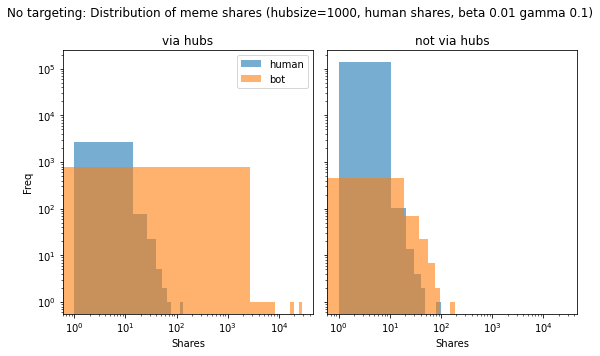

In [6]:
alpha=0.6
fig, (ax1,ax2)= plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,5))
ax1.hist(human_hub_memeshare, label='human', alpha=alpha)
ax1.hist(bot_hub_memeshare, label='bot', alpha=alpha)

ax1.legend()
ax1.set_xlabel('Shares')
ax1.set_ylabel('Freq')
ax1.set_title('via hubs')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.hist(human_nonehub_memeshare, label='human', alpha=alpha)
ax2.hist(bot_nonehub_memeshare, label='bot', alpha=alpha)

ax2.set_title('not via hubs')
ax2.set_xlabel('Shares')

fig.suptitle('No targeting: Distribution of meme shares (hubsize=1000, human shares, beta 0.01 gamma 0.1)')
fig.tight_layout()

Hub targeting

In [14]:
bot_hub_memeshare2, bot_nonehub_memeshare2, human_hub_memeshare2, human_nonehub_memeshare2 = shares_separate_by_hubs(hub, allshare=False)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_18.gml


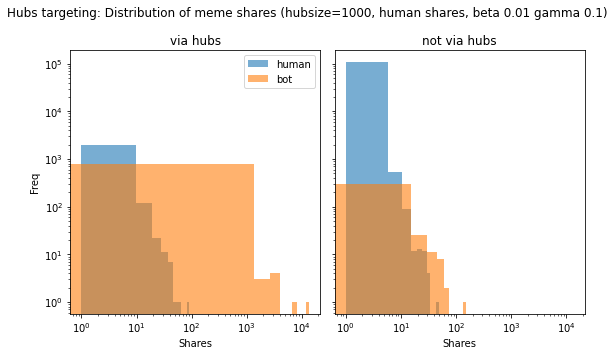

In [8]:
alpha=0.6
fig, (ax1,ax2)= plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,5))
ax1.hist(human_hub_memeshare, label='human', alpha=alpha)
ax1.hist(bot_hub_memeshare, label='bot', alpha=alpha)

ax1.legend()
ax1.set_xlabel('Shares')
ax1.set_ylabel('Freq')
ax1.set_title('via hubs')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.hist(human_nonehub_memeshare, label='human', alpha=alpha)
ax2.hist(bot_nonehub_memeshare, label='bot', alpha=alpha)

ax2.set_title('not via hubs')
ax2.set_xlabel('Shares')

fig.suptitle('Hubs targeting: Distribution of meme shares (hubsize=1000, human shares, beta 0.01 gamma 0.1)')
fig.tight_layout()

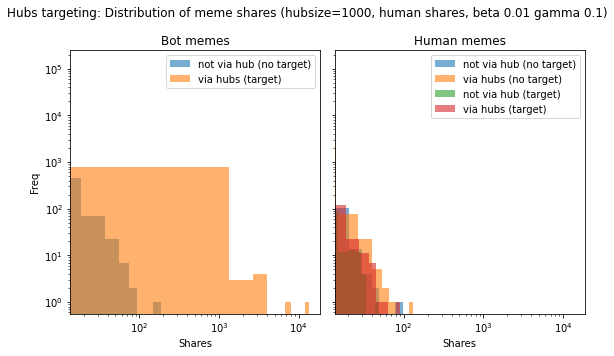

In [19]:
alpha=0.6
fig, (ax1,ax2)= plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,5))
ax1.hist(bot_nonehub_memeshare1, label='not via hub (no target)', alpha=alpha)
# ax1.hist(bot_hub_memeshare1, label='via hubs (no target)', alpha=alpha)
# ax1.hist(bot_nonehub_memeshare2, label='not via hub (target)', alpha=alpha)
ax1.hist(bot_hub_memeshare2, label='via hubs (target)', alpha=alpha)

ax1.legend()
ax1.set_xlabel('Shares')
ax1.set_ylabel('Freq')
ax1.set_title('Bot memes')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.hist(human_nonehub_memeshare1, label='not via hub (no target)', alpha=alpha)
ax2.hist(human_hub_memeshare1, label='via hubs (no target)', alpha=alpha)
ax2.hist(human_nonehub_memeshare2, label='not via hub (target)', alpha=alpha)
ax2.hist(human_hub_memeshare2, label='via hubs (target)', alpha=alpha)

ax2.set_title('Human memes')
ax2.set_xlabel('Shares')
ax2.legend()
fig.suptitle('Hubs targeting: Distribution of meme shares (hubsize=1000, human shares, beta 0.01 gamma 0.1)')
fig.tight_layout()

In [11]:
from scipy.stats import ks_2samp
ks_2samp(bot_nonehub_memeshare, bot_nonehub_memeshare)

KstestResult(statistic=0.0, pvalue=1.0)

# Jaccard similarity

Jaccard similarity of the indeg of meme spreading channels.

Not applicable because the 'spread_via_agents' vectors of memes are of different lengths

## Plot for 2 strategies

In [63]:
from scipy.spatial import distance

def jaccard_sim_meme_spreading_indegs(exp_no):
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    print('network: ', network)
    
    meme_spreading_indegs = []
    for meme in verbose['all_memes'][0]:
        if meme['is_by_bot']==1:
            spread_through= [int(node) for node in meme['spread_via_agents']]
            indegs = graph.degree(vertices, mode=mode, loops=False)
            meme_spreading_indegs += [indegs]
    
    # Get pair-wise jaccard distance:
    jc = []
    for idx,meme in enumerate(meme_spreading_indegs):
        jaccards = [distance.jaccard(meme, othermeme) for othermeme in meme_spreading_indegs[idx:]]
        jc +=jaccards
    return jc

In [ ]:
nohub = 'none_04'
hub = 'hubs_04'
nohub_jc = jaccard_sim_meme_spreading_indegs(nohub)
hub_jc = jaccard_sim_meme_spreading_indegs(hub)

network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_08.gml


/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.
  


network:  /N/slate/baotruon/marketplace/data/igraph/vary_targetgamma/network_18.gml


In [ ]:
fig, ax= plt.subplots()
ax.hist(nohub_jc, label='no targeting')
ax.hist(hub_jc, label='hubs targeting')
plt.legend()
plt.xlabel('Jaccard distance')
plt.ylabel('Freq')
plt.title('Distribution of in-degree similarity of meme spreading channels')

In [56]:
meme_spreading_indegs = []
for meme in verbose['all_memes']:
    if meme['is_by_bot']==1:
        spread_through= [int(node) for node in meme['spread_via_agents']]
        indegs = graph.degree(vertices, mode=mode, loops=False)
        meme_spreading_indegs += [indegs]

In [59]:
from scipy.spatial import distance

In [60]:
# Get pair-wise jaccard distance:
jc = []
for idx,meme in enumerate(meme_spreading_indegs):
    jaccards = [distance.jaccard(meme, othermeme) for othermeme in meme_spreading_indegs[idx:]]
    jc +=jaccards

In [108]:
# plt.hist(jc)
# plt.title('Distribution of in-degree similarity of meme spreading channels')
# plt.xlabel('Jaccard distance')
# plt.ylalbel('Freq')
# # plt.yscale('log')

# Degree distribution

In [59]:
def plot_degree_dist(graph, mode='in'):
    vertices = range(len(graph.vs)) #vertices index
    degs = graph.degree(vertices, mode=mode, loops=False)
    degs = dict(collections.Counter(degs))
    k_per_deg = dict(sorted(degs.items()))
    p_k = {deg: num/len(vertices) for deg,num in k_per_deg.items()}
    plt.scatter(p_k.keys(),p_k.values())
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('p_k')
    plt.xlabel('k')
    plt.title('Degree distribution (%s degree)' %mode)
    plt.show()

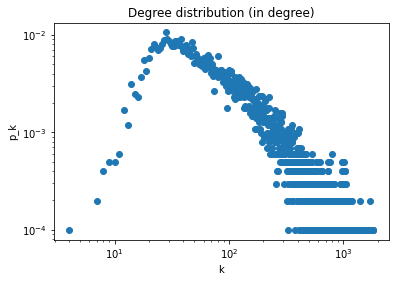

In [60]:
plot_degree_dist(G, mode='in')

Seems like a lot of bad content spread through hub bots 

## Degree of bots and humans

In [22]:
def hum_bot_degree(graph, deg_mode='in'):
    bots =[]
    humans = []
    for vertice in graph.vs:
        if vertice['bot']==0:
            humans += [graph.degree(vertice, mode=mode, loops=False)]
        else:
            bots += [graph.degree(vertice, mode=mode, loops=False)]
    return bots,humans

In [24]:
deg_mode='in'
graph=G
bot_degs, human_degs= hum_bot_degree(graph, deg_mode=deg_mode)

/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.
  
/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Partial string matches of enum members are deprecated since igraph 0.9.3; use strings that identify an enum member unambiguously.
  


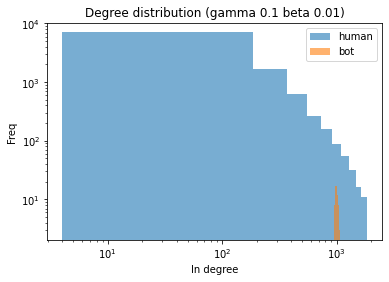

In [27]:
alpha=0.6
plt.hist(human_degs, label='human', alpha=alpha)    
plt.hist(bot_degs, label='bot', alpha=alpha)    
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Freq')
plt.xlabel('In degree')
plt.title('Degree distribution (gamma 0.1 beta 0.01)')
plt.legend()
plt.show()

In [98]:
import seaborn as sns

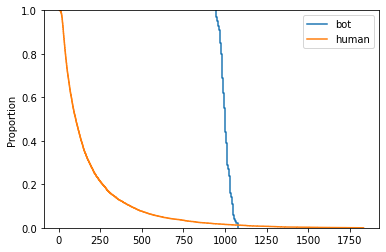

In [107]:
figure, ax= plt.subplots()

sns.ecdfplot(ax=ax, data = bot_degs, complementary=True, label = 'bot')
sns.ecdfplot(ax=ax, data = human_degs, complementary=True, label = 'human')
ax.legend()
# ax.set_xscale('log')

--> Yes, bot degrees are concentrated and have size 

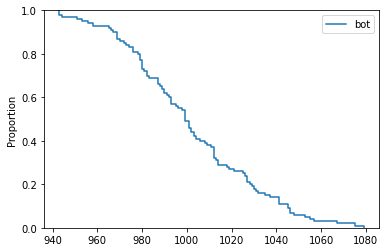

In [104]:
figure, ax= plt.subplots()

sns.ecdfplot(ax=ax, data = bot_degs, complementary=True, label = 'bot')
# sns.ecdfplot(ax=ax, data = human_degs, complementary=True, label = 'human')
ax.legend()
# ax.set_xscale('log')

# Probability of an agent sharing memes from hub 

During the whole simulation

In [9]:
def meme_largest_deg(exp_no, allshare=True):
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    print('network: ', network)

    bots = []
    humans = []
    
    
    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        if meme['is_by_bot']==1:
            if allshare is True:
                shares = meme['human_shares'] + meme['bot_shares']
            else:
                shares = meme['human_shares']
            spread_through= [int(node) for node in meme['spread_via_agents']]
            indegs = graph.degree(spread_through, mode=mode, loops=False)
            viahubs = [i for i in indegs if i>=hub_size]
            if len(viahubs)>0:
                #meme went through at least 1 hub
                hub_meme_share += [shares]
            else:
                nonehub_meme_share += [shares]
    return hub_meme_share, nonehub_meme_share

In [110]:
verbose['all_feeds'][0]

{'65537': [141533,
  141497,
  152,
  141160,
  107629,
  141099,
  141070,
  140966,
  77948,
  140007,
  139892,
  139857,
  139801,
  139696,
  129287],
 '65538': [141467,
  141160,
  77948,
  140463,
  140744,
  152,
  152,
  139086,
  107629,
  152,
  127555,
  138234,
  138094,
  115806,
  137041],
 '5': [113980,
  141433,
  98558,
  141124,
  107629,
  141047,
  140988,
  39752,
  140784,
  140467,
  140443,
  140332,
  140293,
  113980,
  152],
 '32775': [141611,
  141609,
  141603,
  137687,
  141595,
  141547,
  116830,
  141520,
  141513,
  107629,
  141267,
  77948,
  141477,
  141430,
  141429],
 '98314': [141366,
  141497,
  141366,
  77948,
  141279,
  141261,
  98558,
  141124,
  141099,
  107629,
  141062,
  127555,
  140923,
  140896,
  140850],
 '32780': [107629,
  107629,
  140189,
  141611,
  137687,
  141595,
  141545,
  77948,
  141586,
  141507,
  141575,
  141569,
  107629,
  140803,
  141562],
 '131084': [113980,
  141436,
  141567,
  141532,
  141524,
  14149

In [123]:
any(map(str.isalpha, 'ab34'))

True

In [121]:
humans = [agent_id for agent_id in verbose['all_feeds'][0].keys() if any(map(str.isalpha, agent_id)) is False]

In [122]:
len(humans)

10006

In [26]:
len(G.vs)

10106

In [10]:
def prob_spreading_throughhub(exp_no):
    mode='igraph'
    network = os.path.join(DATA_PATH, mode, 'vary_targetgamma', "network_%s.gml" %EXP_NETWORK[exp_no])
    fpath = os.path.join(TRACKING_DIR,'%s.json.gz' %exp_no)
    G = ig.Graph.Read_GML(network)
    verbose = utils.read_json_compressed(fpath)
    deg_mode='in'
    
    bot_memes = []
    human_memes = []
    # humans = [agent_id for agent_id in verbose['all_feeds'][0].keys() if any(map(str.isalpha, agent_id)) is False]
    for agentid, memeids in verbose['all_feeds'][0].items():
        if any(map(str.isalpha, agentid)) is True:
            #skip bots
            continue

        verbose_memes = [meme for meme in verbose['all_memes'][0] if meme['id'] in memeids]
        for meme in verbose_memes:
            spread_through= [int(node) for node in meme['spread_via_agents']]
            indegs = G.degree(spread_through, mode=deg_mode, loops=False)
            largest_indeg = max(indegs)
            if meme['is_by_bot']==1:
                bot_memes += [largest_indeg]
            else:
                human_memes += [largest_indeg]
    return bot_memes, human_memes

In [130]:
nohub = 'none_04'
bot_memes, human_memes = prob_spreading_throughhub(nohub)

In [11]:
import pickle as pkl

In [133]:
pkl.dump(bot_memes, open('%s_trackhubs_botmemes.pkl' %nohub, 'wb'))
pkl.dump(human_memes, open('%s_trackhubs_humanmemes.pkl' %nohub, 'wb'))

In [12]:
hub = 'hubs_04'
hubs_bot_memes, hubs_human_memes = prob_spreading_throughhub(hub)

In [13]:
pkl.dump(hubs_bot_memes, open('%s_trackhubs_botmemes.pkl' %hub, 'wb'))
pkl.dump(hubs_human_memes, open('%s_trackhubs_humanmemes.pkl' %hub, 'wb'))

## Data saved, run from here

In [14]:
nohub = 'none_04'
hub = 'hubs_04'
bot_memes = pkl.load(open('%s_trackhubs_botmemes.pkl' %nohub, 'rb'))
human_memes = pkl.load(open('%s_trackhubs_humanmemes.pkl' %nohub, 'rb'))

# hubs_bot_memes = pkl.load(open('%s_trackhubs_botmemes.pkl' %hub, 'rb'))
# hubs_human_memes = pkl.load(open('%s_trackhubs_humanmemes.pkl' %hub, 'rb'))

In [16]:
import seaborn as sns

Text(0.5, 0.98, 'CCDF: Largest in-deg of spreading nodes (final state)')

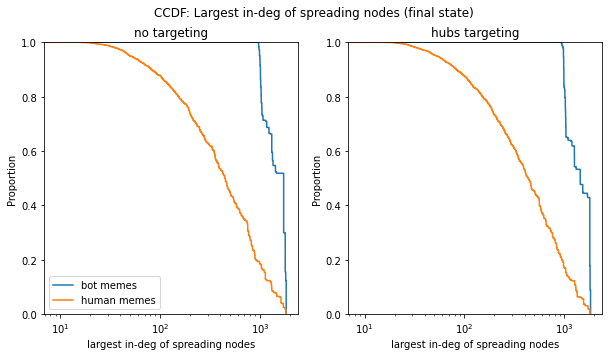

In [19]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5), sharex=True)

sns.ecdfplot(ax=ax1, data = bot_memes, complementary=True, label = 'bot memes')
sns.ecdfplot(ax=ax1, data = human_memes, complementary=True, label = 'human memes')
ax1.legend()
ax1.set_xscale('log')

sns.ecdfplot(ax=ax2, data = hubs_bot_memes, complementary=True, label = 'bot memes')
sns.ecdfplot(ax=ax2, data = hubs_human_memes, complementary=True, label = 'human memes')

ax1.set_title('no targeting')
ax2.set_title('hubs targeting')
ax1.set_xlabel('largest in-deg of spreading nodes')
ax2.set_xlabel('largest in-deg of spreading nodes')

figure.suptitle('CCDF: Largest in-deg of spreading nodes (final state)')
# ax.set_xlim([0, 1])